In [1]:
import pyke
import glob as g
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lightkurve import KeplerTargetPixelFile as ktpf
from astropy.io import fits
import lightkurve
from shutil import copyfile
from pathlib import Path
import subprocess
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.datasets import make_100gaussians_image
from photutils import detect_threshold, detect_sources, deblend_sources
import matplotlib.gridspec as gridspec

PSF centroiding: 100%|██████████| 2533/2533 [00:10<00:00, 244.69it/s]
/home/pal/.local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home/pal/.local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value
/home/pal/.local/lib/python3.6/site-packages/photutils/segmentation/detect.py:128: RuntimeWarning: invalid value encountered in greater
  check_normalization=True) > threshold)


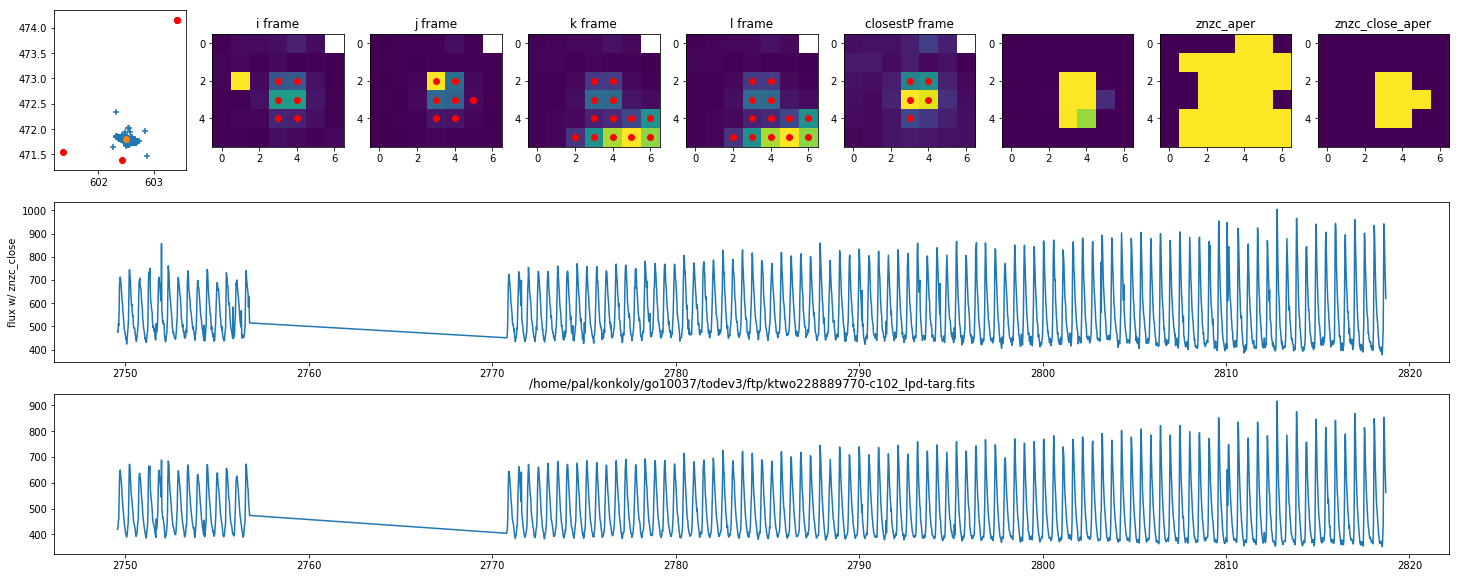

PSF centroiding: 100%|██████████| 302/302 [00:02<00:00, 144.26it/s]


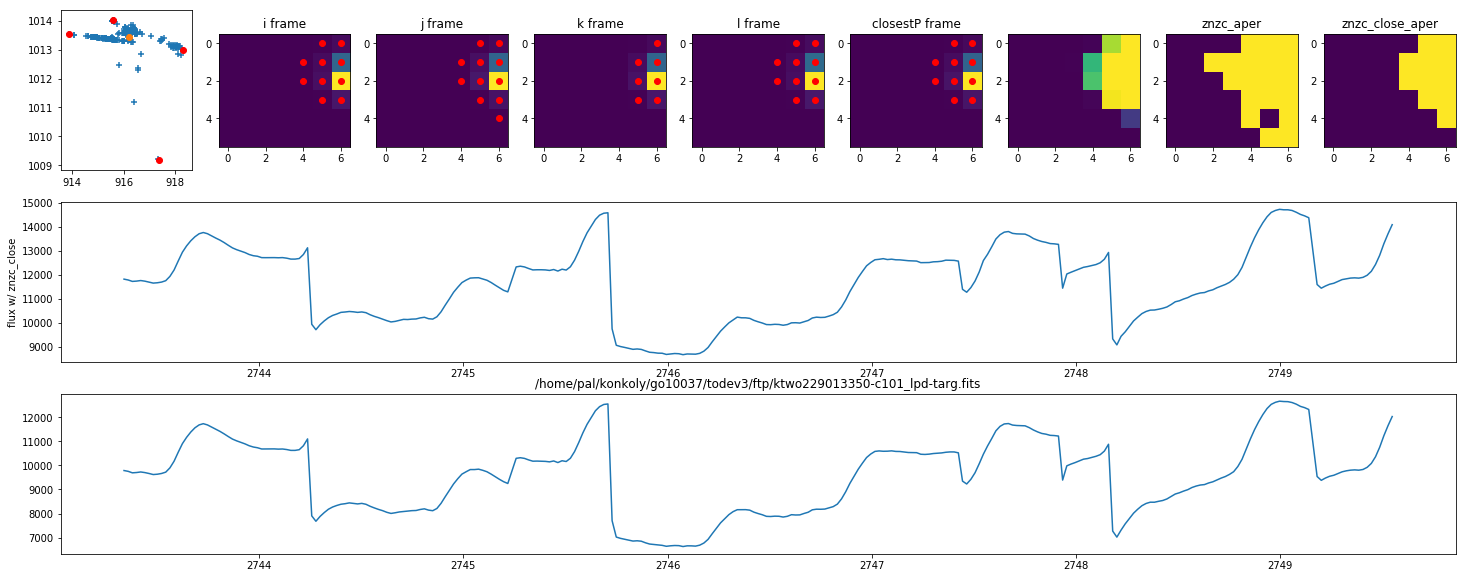

PSF centroiding: 100%|██████████| 2533/2533 [00:12<00:00, 200.09it/s]


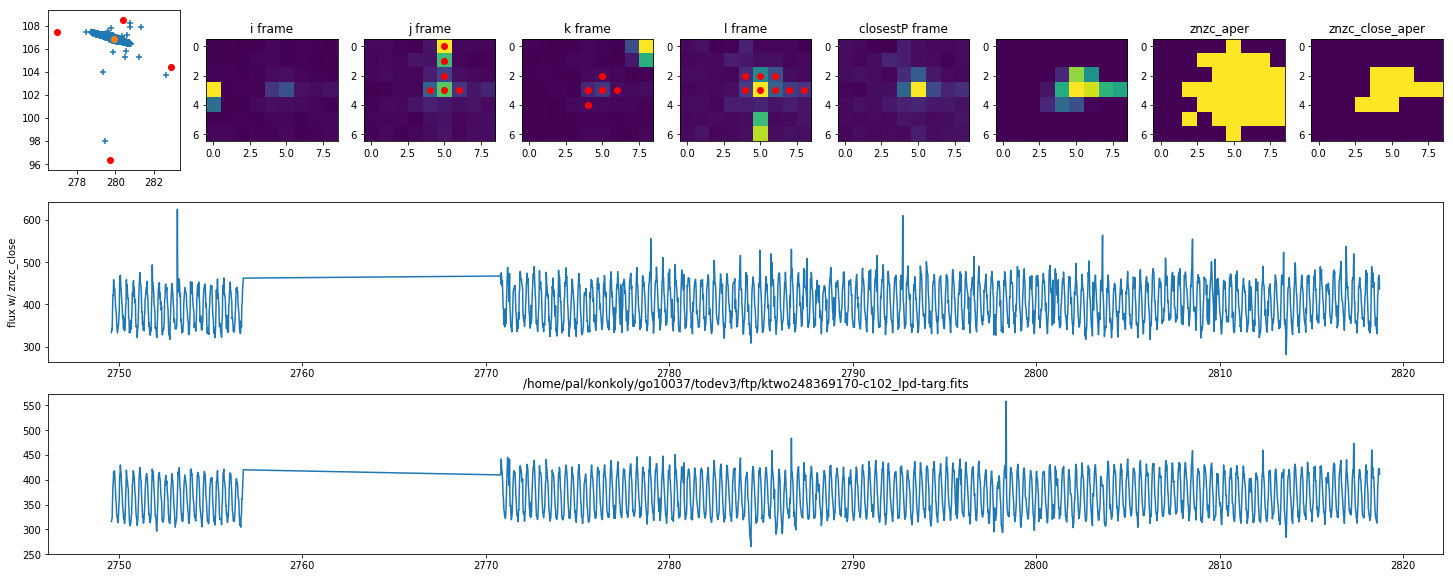

PSF centroiding: 100%|██████████| 302/302 [00:05<00:00, 51.91it/s]
/home/pal/.local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home/pal/.local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value
/home/pal/.local/lib/python3.6/site-packages/photutils/segmentation/detect.py:128: RuntimeWarning: invalid value encountered in greater
  check_normalization=True) > threshold)


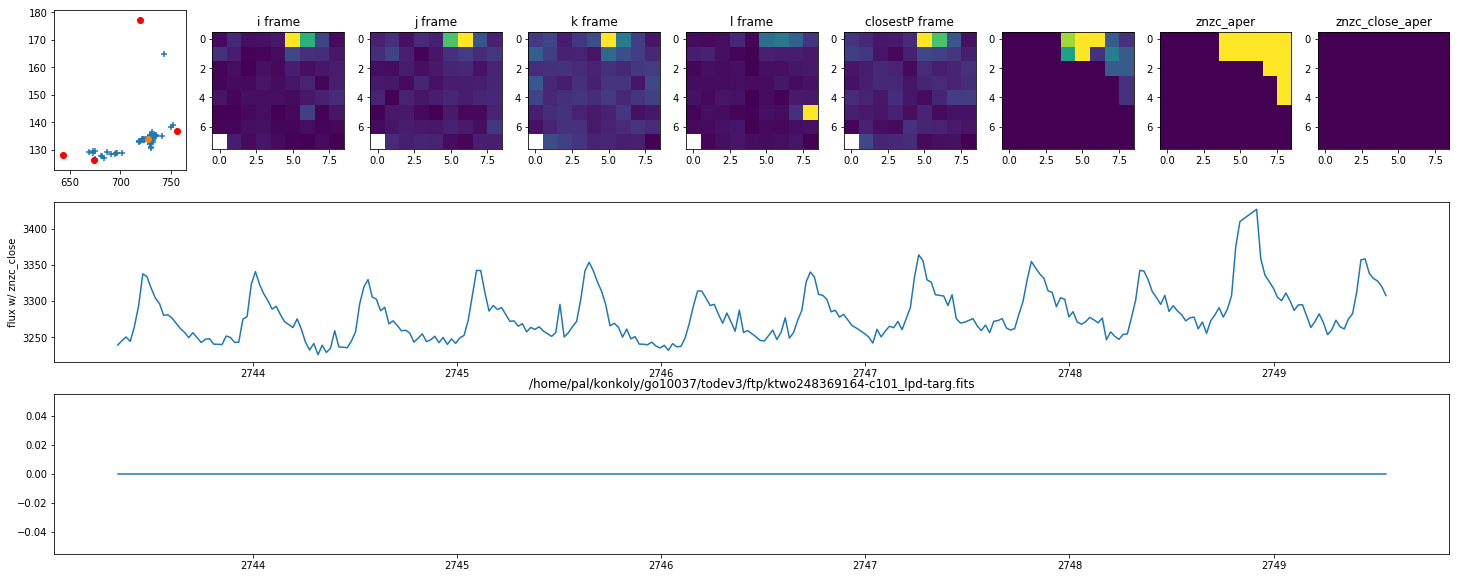

PSF centroiding: 100%|██████████| 302/302 [00:02<00:00, 145.84it/s]
/home/pal/.local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home/pal/.local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value
/home/pal/.local/lib/python3.6/site-packages/photutils/segmentation/detect.py:128: RuntimeWarning: invalid value encountered in greater
  check_normalization=True) > threshold)


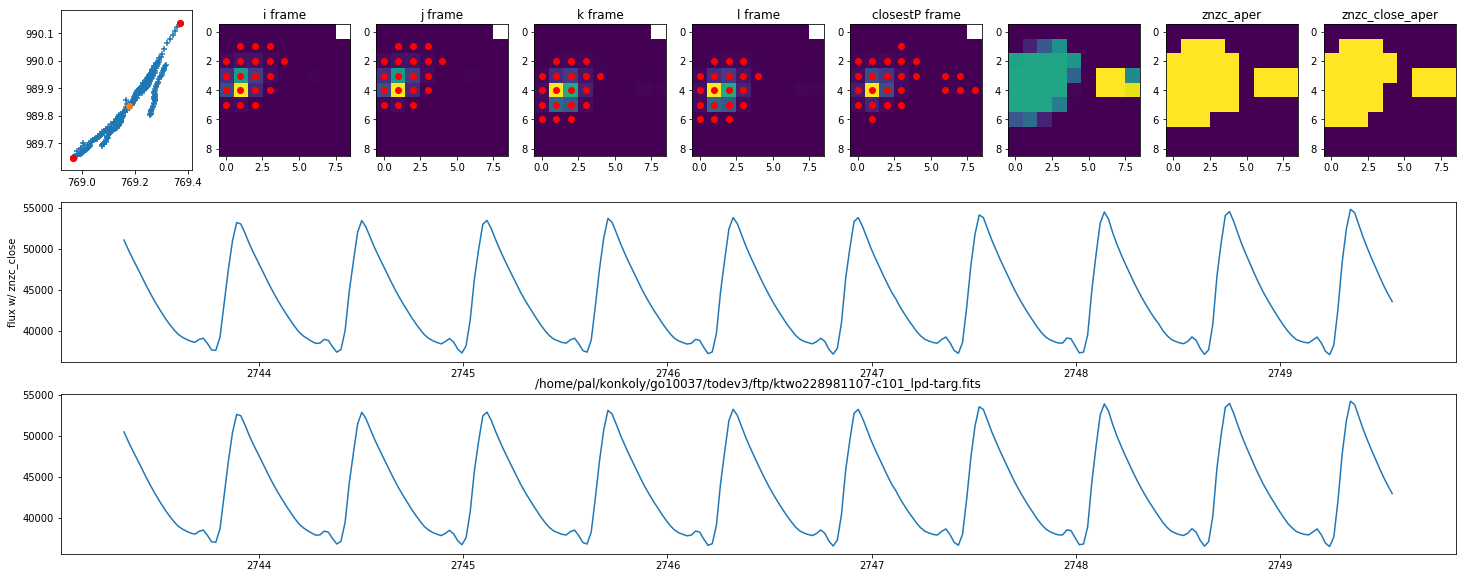

PSF centroiding:  50%|█████     | 152/302 [00:00<00:00, 295.76it/s]/home/pal/.local/lib/python3.6/site-packages/pyke/kepfunc.py:258: RuntimeWarning: overflow encountered in square
  res = np.square(flux - g)
PSF centroiding: 100%|██████████| 302/302 [00:01<00:00, 240.95it/s]


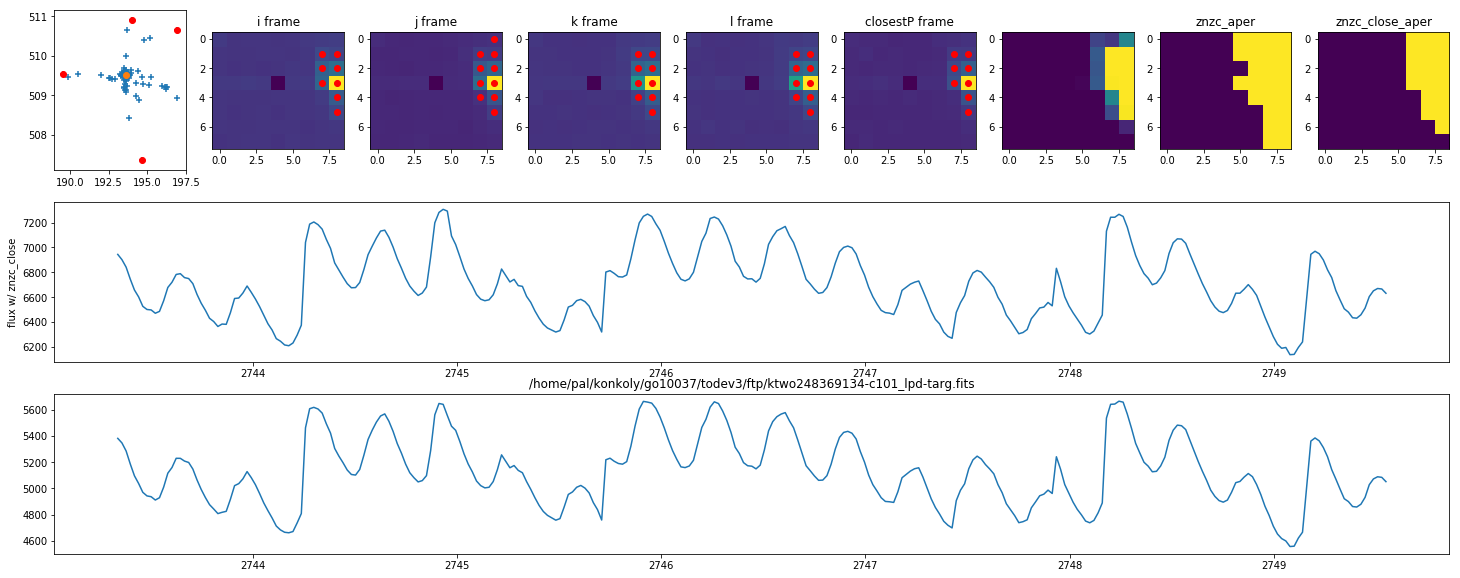

Aperture photometry:  84%|████████▎ | 2117/2533 [00:09<00:01, 225.11it/s]

In [ ]:
OURSTARS=g.glob('/home/pal/konkoly/go10037/todev3/ftp/ktwo*targ.fits')

for q, w in enumerate(OURSTARS):
    if q<=50: #for debug
    #if True: #for debug
        
        #ourstar = g.glob('/home/pal/konkoly/go10037/todev3/ftp/ktwo201243594-c102_lpd-targ2.fits')[0]
        ourstar=w
        
        pyke.kepextract(ourstar,maskfile='ALL',psfcentroid=True,overwrite=True)
        
        #fits_image_filename="/home/pal/konkoly/go10037/todev3/ftp/ktwo201243594-c102_lpd-targ2-kepextract.fits"
        fits_image_filename=w[:-5]+"-kepextract.fits"
        
        tpf=lightkurve.targetpixelfile.KeplerTargetPixelFile(ourstar)
        with fits.open(fits_image_filename) as hdul:
            data=hdul[1].data
        psfc1=data['PSF_CENTR1']
        psfc2=data['PSF_CENTR2']

        mpsfc1=np.mean(psfc1)
        mpsfc2=np.mean(psfc2)
        closestP_index=[-1]
        for index, line in enumerate(psfc1):
            distance=np.abs(np.abs(psfc1[index]**2-mpsfc1**2)+np.abs(psfc2[index]**2-mpsfc2**2))
            if index==0:
                closest=distance
                closestP_index=index
            if index!=0:
                if distance<=closest:
                    closest=distance
                    closestP_index=index

        i, = np.where(psfc1 == psfc1.min())[0]
        j, = np.where(psfc2 == psfc2.min())[0]
        k, = np.where(psfc1 == psfc1.max())[0]
        l, = np.where(psfc2 == psfc2.max())[0]

        tpf=lightkurve.targetpixelfile.KeplerTargetPixelFile(ourstar)

        datainit=tpf.flux[0]

        counter=[(len(datainit[0]))*[0]]*(len(datainit))

        iaper=[];japer=[];kaper=[];laper=[];closestPaper=[];

        for index, line in enumerate(tpf.flux):
             #if index==i or index==j or index==k or index==l:
            if True:  

                data = tpf.flux[index]

                try:
                    threshold = detect_threshold(data, snr=5.)
                    sigma = 3.0 * gaussian_fwhm_to_sigma    # FWHM = 3.
                    kernel = Gaussian2DKernel(sigma, x_size=1, y_size=1)
                    kernel.normalize()
                    segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)
                    segm_deblend = deblend_sources(data, segm, npixels=5, filter_kernel=kernel)

                    counter=counter+segm.data

                    if index==i:
                        iaper=segm.data
                    if index==j:
                        japer=segm.data
                    if index==k:
                        kaper=segm.data
                    if index==l:
                        laper=segm.data
                    if index==closestP_index:
                        closestPaper=segm.data

                except:
                    #print("PROBLEMS W/ FRAME"+str(index))
                    pass
                    
        lenght=len(tpf.flux)
        critical=lenght/20

        znzc=[]
        for index, rows in enumerate(counter):
            znzc.append([])
            #print(index)
            #print(rows)
            for INDEX, each in enumerate(rows):
                #print(znzc[index])
                if each==0:
                    znzc[index].append(0)
                else:
                    znzc[index].append(1)


        znzc_close=[]
        for index, rows in enumerate(counter):
            znzc_close.append([])
            #print(index)
            #print(rows)
            for INDEX, each in enumerate(rows):
                #print(znzc[index])
                if each<critical:
                    znzc_close[index].append(0)
                else:
                    znzc_close[index].append(1)


        xi=[];yi=[]
        for index, line in enumerate(iaper):
                for INDEX, LINE in enumerate(line):
                    if LINE!=0:
                        xi.append(INDEX);yi.append(index)

        xj=[];yj=[]
        for index, line in enumerate(japer):
                for INDEX, LINE in enumerate(line):
                    if LINE!=0:
                        xj.append(INDEX);yj.append(index)

        xk=[];yk=[]
        for index, line in enumerate(kaper):
                for INDEX, LINE in enumerate(line):
                    if LINE!=0:
                        xk.append(INDEX);yk.append(index)

        xl=[];yl=[]
        for index, line in enumerate(laper):
                for INDEX, LINE in enumerate(line):
                    if LINE!=0:
                        xl.append(INDEX);yl.append(index)

        xclosestP=[];yclosestP=[]
        for index, line in enumerate(closestPaper):
                for INDEX, LINE in enumerate(line):
                    if LINE!=0:
                        xclosestP.append(INDEX);yclosestP.append(index)

        %matplotlib inline

        plt.figure(figsize=(25,10))

        gs = gridspec.GridSpec(3, 9)
        ax00 = plt.subplot(gs[0, 0])
        ax01 = plt.subplot(gs[0, 1])
        ax02 = plt.subplot(gs[0, 2])
        ax03 = plt.subplot(gs[0, 3])
        ax04 = plt.subplot(gs[0, 4])
        ax05 = plt.subplot(gs[0, 5])
        ax06 = plt.subplot(gs[0, 6])
        ax07 = plt.subplot(gs[0, 7])
        ax08 = plt.subplot(gs[0, 8])
        ax10 = plt.subplot(gs[1, :])
        ax20 = plt.subplot(gs[2, :])


        ax00.scatter(psfc1,psfc2,marker='+')
        i, = np.where(psfc1 == psfc1.min())[0]
        ax00.scatter(psfc1[i],psfc2[i],c='r')
        j, = np.where(psfc2 == psfc2.min())[0]
        ax00.scatter(psfc1[j],psfc2[j],c='r')
        k, = np.where(psfc1 == psfc1.max())[0]
        ax00.scatter(psfc1[k],psfc2[k],c='r')
        l, = np.where(psfc2 == psfc2.max())[0]
        ax00.scatter(psfc1[l],psfc2[l],c='r')


        mpsfc1=np.mean(psfc1)
        mpsfc2=np.mean(psfc2)
        closestP_index=[-1]
        for index, line in enumerate(psfc1):
            distance=np.abs(np.abs(psfc1[index]**2-mpsfc1**2)+np.abs(psfc2[index]**2-mpsfc2**2))
            if index==0:
                closest=distance
                closestP_index=index
            if index!=0:
                if distance<=closest:
                    closest=distance
                    closestP_index=index
        ax00.scatter(psfc1[closestP_index],psfc2[closestP_index])


        ax01.imshow(tpf.flux[i])
        ax01.scatter(xi,yi,c='r')
        ax01.set_title("i frame")
        
        ax02.imshow(tpf.flux[j])
        ax02.scatter(xj,yj,c='r')
        ax02.set_title("j frame")

        ax03.imshow(tpf.flux[k])
        ax03.scatter(xk,yk,c='r')
        ax03.set_title("k frame")
        
        ax04.imshow(tpf.flux[l])
        ax04.scatter(xl,yl,c='r')
        ax04.set_title("l frame")

        ax05.imshow(tpf.flux[closestP_index])
        ax05.scatter(xclosestP,yclosestP,c='r')
        ax05.set_title("closestP frame")
   
        ax06.imshow(counter)

        ax07.imshow(znzc)
        ax07.set_title("znzc_aper")
        
        ax08.imshow(znzc_close)
        ax08.set_title("znzc_close_aper")


        znzc=np.asarray(znzc)
        znzc_close=np.asarray(znzc_close)

        user_lc = tpf.to_lightcurve(aperture_mask=znzc.astype(bool))
        user_lc = user_lc.remove_nans().remove_outliers()
        ax10.plot(user_lc.time,user_lc.flux)
        ax10.set_ylabel("flux w/ znzc")


        user_lc = tpf.to_lightcurve(aperture_mask=znzc_close.astype(bool))
        user_lc = user_lc.remove_nans().remove_outliers()
        ax20.plot(user_lc.time,user_lc.flux)
        ax10.set_ylabel("flux w/ znzc_close")        
        plt.title(w)
        
        pngname=w+"_autoaper.png"
        plt.savefig(pngname)
        
        plt.show()